### Burgers' equation
Physics form:
$$\frac{\partial u(t,x)}{\partial t} + u(t,x) \frac{\partial u(t,x)}{\partial x} = \nu \frac{\partial^2 u(t,x)}{\partial x^2}$$
$u(t,x)$: velocity of fluid, $\nu$: viscosity of fluid <br><br>

General form:
$$\frac{\partial u(t,x)}{\partial t} + \lambda _{1} u(t,x) \frac{\partial u(t,x)}{\partial x} -\lambda _{2} \frac{\partial^2 u(t,x)}{\partial x^2} = 0$$<br>

In identification, the solution $u(x,t)$ is known and we want to discover the parameters of the equation $F(t, x, u(t, x), \lambda) = 0.$ This is a supervised task, the dataset is constituted of $N$ points, which are randomly selected in the entire space-time domain  $\Omega = [0, 1] \times [-1, 1]$, $S = \{t_i, x_i, u(t_i, x_i)\}_{i=1}^N$, this dataset gives the solution for every $(t, x) \in \Omega$. The information from the boundary & intial conditions is encoded in the dataset, $x \in [-1,1]$, $t \in [0,1]$ and $u(t,x)$ in the interior of $\Omega$. <br>

Define $f := u_t + \lambda _1 u u_x - \lambda _2 u_{xx}$, (link with $F$: $\lambda = (\lambda_1,\lambda_2)$), this will be an approximation of the PDE given by the PINN, ```u(t,x)``` approximation of the exact solution given by the PINN.

The loss is defined by: $MSE = MSE_f + MSE_u$, it is a combination of the PDE loss $MSE_f$ and the training data loss $MSE_u$. <br>
$MSE_f = \frac{1}{N}\Sigma_{i=1}^{N} |f(t_u^i,x_u^i)|^2$ <br>
$MSE_u = \frac{1}{N}\Sigma_{i=1}^{N} |u(t_u^i,x_u^i) - u^i|^2$ <br>

Where $\{t_u^i,x_u^i,u^i\}_{i=1}^{N}$ is the training dataset. ***Note*: here we use the same training set on both losses.**

Expected $\lambda$: $\lambda_1 = 1.0$ and $\lambda_2 = \frac{0.01}{\pi} \approx 0.00318$

### DNN

In [1]:
import torch
from torch import nn 
from collections import OrderedDict
torch.manual_seed(0)

class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(len(layers) - 2): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (len(layers) - 2), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)

        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

### PINN

In [2]:
import torch.optim as optim

class PINN():
    def __init__(self, layers, xt_train, u_train, tol=1e-5, hs=50, verbose=True): 
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.verbose = verbose
        if self.verbose:
            print(f"device used: {self.device}")
            print(f"xt_train shape: {xt_train.shape}")
            print(f"u_train shape: {u_train.shape}")
        
        self.x_tr = torch.tensor(xt_train[:, 0:1], requires_grad=True).float().to(self.device) 
        self.t_tr = torch.tensor(xt_train[:, 1:2], requires_grad=True).float().to(self.device) 
        self.u_tr = torch.tensor(u_train).float().to(self.device) 
        
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(self.device) #random guess
        self.lambda_2 = torch.tensor([-6.0], requires_grad=True).to(self.device) #random guess 
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        self.net = DNN(layers).to(self.device)
        self.net.register_parameter('lambda_1', self.lambda_1)
        self.net.register_parameter('lambda_2', self.lambda_2)
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
        
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=hs,
            tolerance_grad=tol, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"    
        )
        
        self.iter = 1
        
    def net_u(self, x, t):
        u = self.net(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = self.lambda_1        
        lambda_2 = torch.exp(self.lambda_2)
        
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx
        return f

    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_tr, self.t_tr)
        f_pred = self.net_f(self.x_tr, self.t_tr) 
        
        loss_u = torch.mean((self.u_tr - u_pred) ** 2) 
        loss_f = torch.mean(f_pred ** 2) 
        
        loss = loss_u + loss_f 
        
        loss.backward() 
        
        self.iter += 1
        if self.verbose:
            if self.iter % 100 == 0:
                print(
                    'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e, Lambda1: %.5f, Lambda2: %.5f' % (self.iter, loss.item(), loss_u.item(), loss_f.item(), self.lambda_1.item(), torch.exp(self.lambda_2.detach()).item())
                )
        return loss
    
    def train(self):
        self.net.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, xt):
        x = torch.tensor(xt[:, 0:1], requires_grad=True).float().to(self.device) #get x from pair
        t = torch.tensor(xt[:, 1:2], requires_grad=True).float().to(self.device) #get t from pair

        self.net.eval()
        
        u = self.net_u(x, t) 
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

### Data Generation

In [3]:
import scipy.io
import numpy as np
import time

lambda_1_true = 1.0
lambda_2_true = 0.01/np.pi
Nu = 2000 #max 25600

sol_data = scipy.io.loadmat('burgers_shock.mat')
x_sol = sol_data['x'].flatten()[:,None] #(256, 1)
t_sol = sol_data['t'].flatten()[:,None] #(256, 1)
U_sol = np.real(sol_data['usol']).T #(100, 256)
X, T = np.meshgrid(x_sol, t_sol)
xt_sol = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) #(25600, 2)
u_sol = U_sol.flatten()[:,None] #(25600, 1)           

idx = np.random.choice(xt_sol.shape[0], Nu, replace=False)
xt_train = xt_sol[idx,:] #(2000, 2)
u_train = u_sol[idx,:] #(2000, 2)

def generate_data(Nu, xt_sol, u_sol):
    idx = np.random.choice(xt_sol.shape[0], Nu, replace=False)
    xt_train = xt_sol[idx,:]
    u_train = u_sol[idx,:]
    return xt_train, u_train

### Create and train

In [4]:
%%time

nb_nodes = 20
nb_hidden_layers = 9
layers = np.hstack([np.array([2]),np.full(nb_hidden_layers, nb_nodes),np.array([1])])

model = PINN(layers, xt_train, u_train, tol=1e-5, hs=50)

model.train()

device used: cuda:0
xt_train shape: (2000, 2)
u_train shape: (2000, 1)
Iter 100, Loss: 1.73642e-02, Loss_u: 1.53370e-02, Loss_f: 2.02727e-03, Lambda1: 0.34298, Lambda2: 0.00260
Iter 200, Loss: 7.87805e-03, Loss_u: 5.58411e-03, Loss_f: 2.29394e-03, Lambda1: 0.60224, Lambda2: 0.00351
Iter 300, Loss: 3.57637e-03, Loss_u: 2.23129e-03, Loss_f: 1.34507e-03, Lambda1: 0.79106, Lambda2: 0.00497
Iter 400, Loss: 2.20594e-03, Loss_u: 1.14449e-03, Loss_f: 1.06145e-03, Lambda1: 0.89444, Lambda2: 0.00566
Iter 500, Loss: 1.58628e-03, Loss_u: 7.49160e-04, Loss_f: 8.37124e-04, Lambda1: 0.93579, Lambda2: 0.00562
Iter 600, Loss: 1.13846e-03, Loss_u: 5.07166e-04, Loss_f: 6.31297e-04, Lambda1: 0.94687, Lambda2: 0.00521
Iter 700, Loss: 8.59779e-04, Loss_u: 3.70093e-04, Loss_f: 4.89686e-04, Lambda1: 0.96110, Lambda2: 0.00484
Iter 800, Loss: 6.60685e-04, Loss_u: 2.52643e-04, Loss_f: 4.08042e-04, Lambda1: 0.96727, Lambda2: 0.00461
Iter 900, Loss: 5.09929e-04, Loss_u: 2.06862e-04, Loss_f: 3.03067e-04, Lambda1: 0

### Evaluate

In [5]:
def l2_norm(pred, true):
    return np.linalg.norm(true - pred,2)/np.linalg.norm(true, 2)

def mse(pred, true):
    return ((pred - true)**2).mean(axis=0).item()

u_pred_tr, f_pred_tr = model.predict(xt_train)

lambda_1_pred = model.lambda_1.detach().cpu().numpy().item()
lambda_2_pred = model.lambda_2.detach().cpu().numpy().item()
lambda_2_pred = np.exp(lambda_2_pred)        
relative_error_lambda_1 = np.abs(lambda_1_pred - lambda_1_true) / lambda_1_true * 100
relative_error_error_lambda_2 = np.abs(lambda_2_pred - lambda_2_true) / lambda_2_true * 100

l2_u_tr = l2_norm(u_pred_tr, u_train)  
mse_u_tr = mse(u_pred_tr, u_train)
mse_f_tr = mse(f_pred_tr, np.zeros(f_pred_tr.shape))

u_pred_te, f_pred_te = model.predict(xt_sol)

l2_u_te = l2_norm(u_pred_te, u_sol)  
mse_u_te = mse(u_pred_te, u_sol)
mse_f_te = mse(f_pred_te, np.zeros(f_pred_te.shape))


print(f'Train L2 Error u: %e' % (l2_u_tr))
print(f'Test L2 Error u: %e' % (l2_u_te)) 
print(f'Train MSE Error u: %e' % (mse_u_tr))
print(f'Test MSE Error u: %e' % (mse_u_te))
print(f'Train MSE Error f: %e' % (mse_f_tr)) 
print(f'Test MSE Error f: %e' % (mse_f_te)) 


print('Error lambda_1: %.5f%%' % (relative_error_lambda_1))                             
print('Error lambda_2: %.5f%%' % (relative_error_error_lambda_2))
print(f"Lambda_1= {lambda_1_pred}, lambda_2= {lambda_2_pred}")

Train L2 Error u: 5.423414e-03
Test L2 Error u: 5.730471e-03
Train MSE Error u: 1.101131e-05
Test MSE Error u: 1.239352e-05
Train MSE Error f: 2.330900e-05
Test MSE Error f: 1.170825e-03
Error lambda_1: 0.40659%
Error lambda_2: 0.85226%
Lambda_1= 0.9959340691566467, lambda_2= 0.0032102271108727914


### Plot

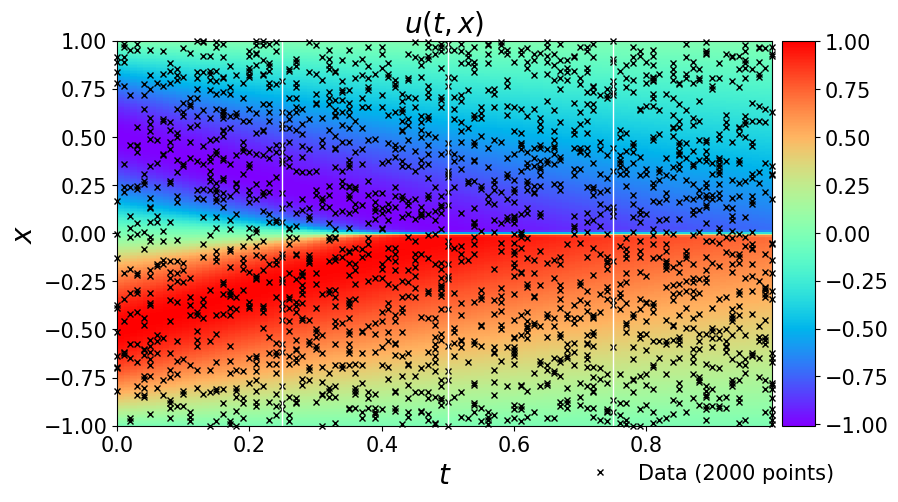

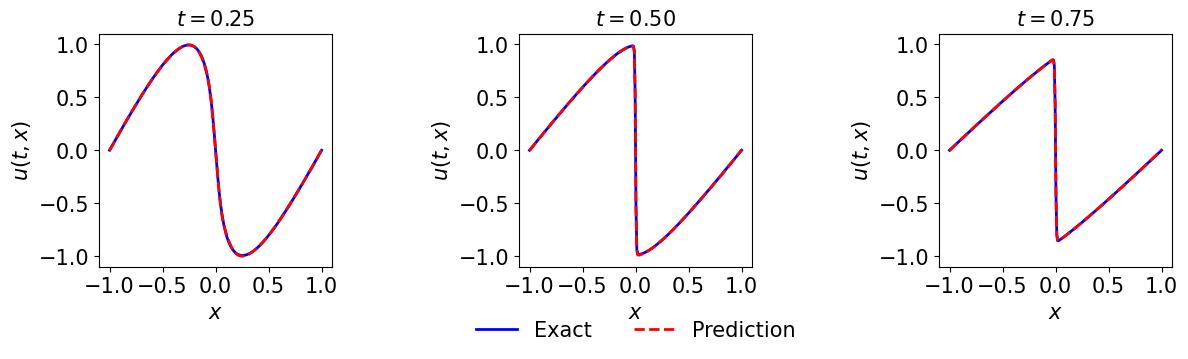

In [6]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

#first plot
U_pred = griddata(xt_sol, u_pred_te.flatten(), (X, T), method='cubic') #100, 256, the test output

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t_sol.min(), t_sol.max(), x_sol.min(), x_sol.max()], 
              origin='lower', aspect='auto') #show pseudocolor image, u(t,x) output of xt_sol of shape (25600, 2)


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

# show training points (Nf, 2), that were used to train the network
ax.plot(
    xt_train[:,1], 
    xt_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x_sol.min(), x_sol.max(), 2)[:,None]
ax.plot(t_sol[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_sol[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_sol[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()


#second plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)
ax.remove()

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x_sol,U_sol[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_sol,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x_sol,U_sol[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_sol,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x_sol,U_sol[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_sol,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()


### Add Noise

In [7]:
%%time

noise = 0.01 #1% uncorrelated noise

u_train_noise = u_train + noise * np.std(u_train) * np.random.randn(u_train.shape[0], u_train.shape[1])

model = PINN(layers, xt_train, u_train_noise, tol=1e-5, hs=50)

model.train()

device used: cuda:0
xt_train shape: (2000, 2)
u_train shape: (2000, 1)
Iter 100, Loss: 1.73240e-02, Loss_u: 1.48675e-02, Loss_f: 2.45643e-03, Lambda1: 0.34388, Lambda2: 0.00284
Iter 200, Loss: 8.57699e-03, Loss_u: 6.33614e-03, Loss_f: 2.24084e-03, Lambda1: 0.59632, Lambda2: 0.00327
Iter 300, Loss: 4.86797e-03, Loss_u: 3.27153e-03, Loss_f: 1.59645e-03, Lambda1: 0.70916, Lambda2: 0.00358
Iter 400, Loss: 3.03399e-03, Loss_u: 1.74304e-03, Loss_f: 1.29095e-03, Lambda1: 0.81195, Lambda2: 0.00382
Iter 500, Loss: 2.04098e-03, Loss_u: 9.62943e-04, Loss_f: 1.07804e-03, Lambda1: 0.87078, Lambda2: 0.00394
Iter 600, Loss: 1.50799e-03, Loss_u: 6.60046e-04, Loss_f: 8.47942e-04, Lambda1: 0.89487, Lambda2: 0.00405
Iter 700, Loss: 1.14811e-03, Loss_u: 4.04152e-04, Loss_f: 7.43954e-04, Lambda1: 0.93560, Lambda2: 0.00408
Iter 800, Loss: 7.36944e-04, Loss_u: 2.65315e-04, Loss_f: 4.71629e-04, Lambda1: 0.95590, Lambda2: 0.00408
Iter 900, Loss: 5.95208e-04, Loss_u: 2.10551e-04, Loss_f: 3.84657e-04, Lambda1: 0

### Evaluate noise

In [8]:
u_pred_tr_noise, f_pred_tr_noise = model.predict(xt_train)

lambda_1_noise_pred = model.lambda_1.detach().cpu().numpy().item()
lambda_2_noise_pred = model.lambda_2.detach().cpu().numpy().item()
lambda_2_noise_pred = np.exp(lambda_2_noise_pred)        
relative_error_lambda_1_noise = np.abs(lambda_1_noise_pred - lambda_1_true) / lambda_1_true * 100
relative_error_lambda_2_noise = np.abs(lambda_2_noise_pred - lambda_2_true) / lambda_2_true * 100

l2_u_tr_noise = l2_norm(u_pred_tr_noise, u_train)  
mse_u_tr_noise = mse(u_pred_tr_noise, u_train)
mse_f_tr_noise = mse(f_pred_tr_noise, np.zeros(f_pred_tr_noise.shape))

u_pred_te_noise, f_pred_te_noise = model.predict(xt_sol)

l2_u_te_noise = l2_norm(u_pred_te_noise, u_sol)  
mse_u_te_noise = mse(u_pred_te_noise, u_sol)
mse_f_te_noise = mse(f_pred_te_noise, np.zeros(f_pred_te_noise.shape))


print(f'Train L2 Error u: %e' % (l2_u_tr_noise))
print(f'Test L2 Error u: %e' % (l2_u_te_noise)) 
print(f'Train MSE Error u: %e' % (mse_u_tr_noise))
print(f'Test MSE Error u: %e' % (mse_u_te_noise)) 
print(f'Train MSE Error f: %e' % (mse_f_tr_noise)) 
print(f'Test MSE Error f: %e' % (mse_f_te_noise)) 


print('Error lambda_1: %.5f%%' % (relative_error_lambda_1))                             
print('Error lambda_2: %.5f%%' % (relative_error_error_lambda_2))
print(f"Lambda_1= {lambda_1_noise_pred}, lambda_2= {lambda_2_noise_pred}")

Train L2 Error u: 1.641109e-03
Test L2 Error u: 2.652290e-03
Train MSE Error u: 1.008251e-06
Test MSE Error u: 2.654949e-06
Train MSE Error f: 3.553668e-06
Test MSE Error f: 4.757446e-04
Error lambda_1: 0.40659%
Error lambda_2: 0.85226%
Lambda_1= 0.9992544054985046, lambda_2= 0.003239576462119474


### Plot

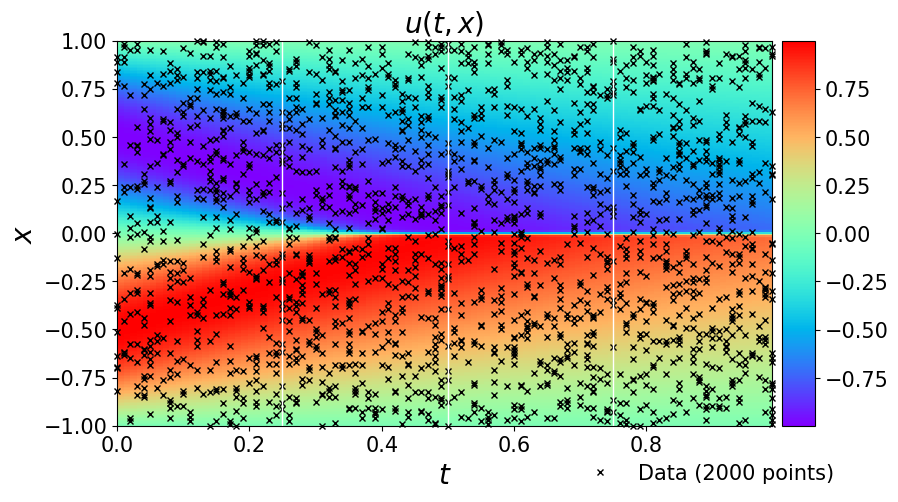

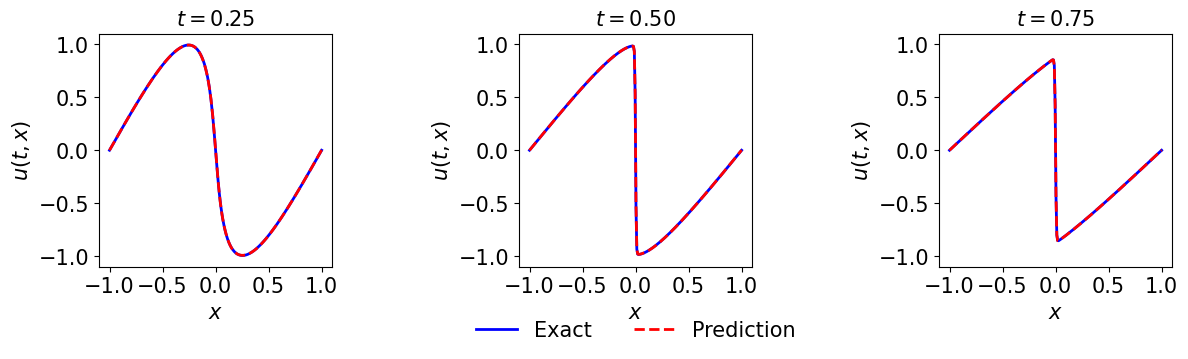

In [9]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

#first plot
U_pred = griddata(xt_sol, u_pred_te_noise.flatten(), (X, T), method='cubic')

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t_sol.min(), t_sol.max(), x_sol.min(), x_sol.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    xt_train[:,1], 
    xt_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x_sol.min(), x_sol.max(), 2)[:,None]
ax.plot(t_sol[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_sol[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_sol[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()


#second plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)
ax.remove()

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x_sol,U_sol[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_sol,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x_sol,U_sol[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_sol,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x_sol,U_sol[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_sol,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

### Network architecture comparison

In [10]:
%%time

nb_neurons = [10, 20, 40]
nb_hidden_layers = [2, 4, 6, 8, 10]

L2_u_1 = list()
MSE_u_1 = list()
MSE_f_1 = list()
rel_error_lambda_1_1 = list()
rel_error_lambda_2_1 = list()

for i in range(len(nb_hidden_layers)):
    for j in range(len(nb_neurons)):
        layers = np.hstack([np.array([2]),np.full(nb_hidden_layers[i], nb_neurons[j]),np.array([1])])
        #verbose = False
        model = PINN(layers, xt_train, u_train, tol = 1e-5, hs = 50, verbose = False)
        model.train()
        lambda_1_pred = model.lambda_1.detach().cpu().numpy().item()
        lambda_2_pred = model.lambda_2.detach().cpu().numpy().item()
        lambda_2_pred = np.exp(lambda_2_pred)
        
        u_pred_tr, f_pred_tr = model.predict(xt_train)
        u_pred_te, f_pred_te = model.predict(xt_sol)
        
        L2_u_1.append(l2_norm(u_pred_te, u_sol))
        MSE_u_1.append(mse(u_pred_te, u_sol))
        MSE_f_1.append(mse(f_pred_te, np.zeros(f_pred_te.shape)))
        
        rel_error_lambda_1_1.append(np.abs(lambda_1_pred - lambda_1_true) / lambda_1_true * 100)
        rel_error_lambda_2_1.append(np.abs(lambda_2_pred - lambda_2_true) / lambda_2_true * 100)
        
        print('l: %d, n: %d, MSE_u_tr: %.2e, MSE_f_tr: %.2e, MSE_u_te: %.2e, MSE_f_te: %.2e, l_1: %f,  l_2: %f' % (nb_hidden_layers[i], nb_neurons[j], mse(u_pred_tr, u_train), mse(f_pred_tr, np.zeros(f_pred_tr.shape)), MSE_u_1[-1], MSE_f_1[-1], lambda_1_pred, lambda_2_pred))
        

best_idx = np.argmin(L2_u_1)
best_nb_layers, best_nb_neurons = np.unravel_index(best_idx, (len(nb_hidden_layers),len(nb_neurons)))

print("\n")
print(f"Best test perf l={nb_hidden_layers[best_nb_layers]}, n={nb_neurons[best_nb_neurons]}, l2_u_te={L2_u_1[best_idx]}, mse_u_te={MSE_u_1[best_idx]}, mse_f_te={MSE_f_1[best_idx]}, error_l1={rel_error_lambda_1_1[best_idx]}, error_l2={rel_error_lambda_2_1[best_idx]}")

"""
print("\n")
out = list(zip(L2_u_1, rel_error_lambda_1_1, rel_error_lambda_2_1))
for i in out:
    print(i)"""

l: 2, n: 10, MSE_u_tr: 1.32e-03, MSE_f_tr: 8.13e-04, MSE_u_te: 1.53e-03, MSE_f_te: 2.27e-03, l_1: 0.891145,  l_2: 0.006139
l: 2, n: 20, MSE_u_tr: 3.03e-04, MSE_f_tr: 2.29e-04, MSE_u_te: 4.14e-04, MSE_f_te: 3.43e-03, l_1: 0.966722,  l_2: 0.003779
l: 2, n: 40, MSE_u_tr: 4.18e-04, MSE_f_tr: 2.32e-04, MSE_u_te: 5.31e-04, MSE_f_te: 5.78e-03, l_1: 0.972216,  l_2: 0.004572
l: 4, n: 10, MSE_u_tr: 3.52e-05, MSE_f_tr: 9.33e-05, MSE_u_te: 4.52e-05, MSE_f_te: 3.33e-03, l_1: 0.986012,  l_2: 0.003282
l: 4, n: 20, MSE_u_tr: 8.22e-06, MSE_f_tr: 1.90e-05, MSE_u_te: 1.09e-05, MSE_f_te: 4.34e-03, l_1: 0.998360,  l_2: 0.003159
l: 4, n: 40, MSE_u_tr: 3.46e-06, MSE_f_tr: 9.65e-06, MSE_u_te: 6.41e-06, MSE_f_te: 2.52e-03, l_1: 0.997494,  l_2: 0.003210
l: 6, n: 10, MSE_u_tr: 3.43e-06, MSE_f_tr: 1.39e-05, MSE_u_te: 7.13e-06, MSE_f_te: 1.58e-03, l_1: 0.998368,  l_2: 0.003206
l: 6, n: 20, MSE_u_tr: 7.62e-07, MSE_f_tr: 3.44e-06, MSE_u_te: 9.55e-07, MSE_f_te: 4.78e-04, l_1: 0.999342,  l_2: 0.003189
l: 6, n: 40, MSE

'\nprint("\n")\nout = list(zip(L2_u_1, rel_error_lambda_1_1, rel_error_lambda_2_1))\nfor i in out:\n    print(i)'

### Data size comparison

In [11]:
%%time

Nu = [10, 50 , 100, 200]
noise = [0.0, 0.01, 0.05, 0.1]
L2_u_2 = list()
MSE_u_2 = list()
MSE_f_2 = list()
rel_error_lambda_1_2 = list()
rel_error_lambda_2_2 = list()

neurons_per_layer = 20
hidden_layers = 9
layers = np.hstack([np.array([2]),np.full(hidden_layers, neurons_per_layer),np.array([1])])

for i in range(len(Nu)):
    xt_train, u_train = generate_data(Nu[i], xt_sol, u_sol)
    #print(xt_train.shape, u_train.shape)
    for j in range(len(noise)):
        
        #verbose = False
        u_train_noise = u_train + noise[j] * np.std(u_train) * np.random.randn(u_train.shape[0], u_train.shape[1])
        model = PINN(layers, xt_train, u_train_noise, tol=1e-5, hs=50, verbose=False)
        model.train()
        
        lambda_1_pred = model.lambda_1.detach().cpu().numpy().item()
        lambda_2_pred = model.lambda_2.detach().cpu().numpy().item()
        lambda_2_pred = np.exp(lambda_2_pred)
        rel_error_lambda_1_2.append(np.abs(lambda_1_pred - lambda_1_true) / lambda_1_true * 100)
        rel_error_lambda_2_2.append(np.abs(lambda_2_pred - lambda_2_true) / lambda_2_true * 100)
        
        u_pred_tr, f_pred_tr = model.predict(xt_train)
        u_pred_te, f_pred_te = model.predict(xt_sol)
        
        L2_u_2.append(l2_norm(u_pred_te, u_sol))
        MSE_u_2.append(mse(u_pred_te, u_sol))
        MSE_f_2.append(mse(f_pred_te, np.zeros(f_pred_te.shape)))
        
        
        print('N: %d, n: %.2f, MSE_u_tr: %.2e, MSE_f_tr: %.2e, MSE_u_te: %.2e, MSE_f_te: %.2e, l_1: %f,  l_2: %f' % (Nu[i], noise[j], mse(u_pred_tr, u_train), mse(f_pred_tr, np.zeros(f_pred_tr.shape)), MSE_u_1[-1], MSE_f_1[-1], lambda_1_pred, lambda_2_pred))

        
best_idx = np.argmin(L2_u_2)
best_nu, best_noise = np.unravel_index(best_idx, (len(Nu),len(noise)))

print("\n")
print(f"Best test perf Nu={Nu[best_nu]}, noise={noise[best_noise]}, l2_u_te={L2_u_2[best_idx]}, mse_u_te={MSE_u_2[best_idx]}, mse_f_te={MSE_f_2[best_idx]}, l1={rel_error_lambda_1_2[best_idx]}, l2={rel_error_lambda_2_2[best_idx]}")

"""
print("\n")
out = list(zip(L2_u_2, rel_error_lambda_1_2, rel_error_lambda_2_2))
for i in out:
    print(i)"""

N: 10, n: 0.00, MSE_u_tr: 7.90e-06, MSE_f_tr: 4.65e-07, MSE_u_te: 1.48e-06, MSE_f_te: 3.08e-03, l_1: 1.023490,  l_2: 0.005964
N: 10, n: 0.01, MSE_u_tr: 2.15e-05, MSE_f_tr: 1.54e-06, MSE_u_te: 1.48e-06, MSE_f_te: 3.08e-03, l_1: 0.963650,  l_2: 0.002373
N: 10, n: 0.05, MSE_u_tr: 5.81e-04, MSE_f_tr: 6.68e-08, MSE_u_te: 1.48e-06, MSE_f_te: 3.08e-03, l_1: 0.818752,  l_2: 0.002989
N: 10, n: 0.10, MSE_u_tr: 3.20e-03, MSE_f_tr: 1.24e-10, MSE_u_te: 1.48e-06, MSE_f_te: 3.08e-03, l_1: 0.483224,  l_2: 0.004114
N: 50, n: 0.00, MSE_u_tr: 7.09e-07, MSE_f_tr: 8.10e-07, MSE_u_te: 1.48e-06, MSE_f_te: 3.08e-03, l_1: 1.004112,  l_2: 0.001623
N: 50, n: 0.01, MSE_u_tr: 1.36e-03, MSE_f_tr: 1.08e-03, MSE_u_te: 1.48e-06, MSE_f_te: 3.08e-03, l_1: 0.830966,  l_2: 0.001319
N: 50, n: 0.05, MSE_u_tr: 7.77e-04, MSE_f_tr: 2.37e-05, MSE_u_te: 1.48e-06, MSE_f_te: 3.08e-03, l_1: 0.956092,  l_2: 0.003811
N: 50, n: 0.10, MSE_u_tr: 3.87e-03, MSE_f_tr: 1.20e-03, MSE_u_te: 1.48e-06, MSE_f_te: 3.08e-03, l_1: 0.697835,  l_2: 0

'\nprint("\n")\nout = list(zip(L2_u_2, rel_error_lambda_1_2, rel_error_lambda_2_2))\nfor i in out:\n    print(i)'